In [1]:

import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from scipy import sparse
import pyLDAvis.gensim
import gensim
from gensim.matutils  import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.linear_model import Ridge
import seaborn as sns

/home/misha/environments/my_env/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
 # Целевой признак - число рекомендаций (лайков) статьи, 
    # приведенные в статье значения - логарифм с единицей
    # от числа рекомендаций
path_to_train = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/train.json'
path_to_data = '/home/misha/environments/my_env/MyProjects/HowGoodIsYourArticle/'


In [4]:
!ls -l $path_to_data

итого 3806312
-rw-rw-r-- 1 misha misha     874228 дек 11 21:52 first_ridge3.csv
-rw-rw-r-- 1 misha misha     870760 дек 11 22:03 first_ridge4.csv
-rw-rw-r-- 1 misha misha     870760 дек 11 18:07 first_ridge.csv
-rw-rw-r-- 1 misha misha     528309 дек 14 13:18 MediumArticle_baseline_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     848271 дек 25 17:55 MediumArticle_Ridge_baseline_tf-idf_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     735235 дек 22 13:14 MediumArticle_Ridge_baseline_ubuntu.ipynb
-rw-rw-r-- 1 misha misha      76041 дек 25 18:17 MediumArticle_ubuntu.ipynb
-rw-rw-r-- 1 misha misha     884217 ноя 29  2019 sample_submission.csv
-rw-rw-r-- 1 misha misha 1156020029 ноя 29  2019 test.json
-rw-rw-r-- 1 misha misha     555138 ноя 29  2019 test_log1p_recommends.csv
-rw-rw-r-- 1 misha misha 2086185062 ноя 29  2019 train.json
-rw-rw-r-- 1 misha misha     912544 ноя 29  2019 train_log1p_recommends.csv
-rw-rw-r-- 1 misha misha  648268208 дек 11 15:37 train_raw_content.txt


#### Функция для чтения JSON файла (без сбоев при исп. escape-символов)

In [5]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result



#### Функция, берущая json файл, убирающая html-теги, и оставляющая только текст статьи

In [6]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list



In [7]:
%%time
train_raw_content = preprocess(path_to_inp_json_file=\
                               os.path.join(path_to_data, 
                                                'train.json'))


<ipython-input-6-2e360253a763>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):



CPU times: user 2min 57s, sys: 2.24 s, total: 2min 59s
Wall time: 2min 58s


In [8]:
%%time
test_raw_content = preprocess(path_to_inp_json_file=\
                              os.path.join(path_to_data, 'test.json'))



<ipython-input-6-2e360253a763>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(inp_file):



CPU times: user 1min 41s, sys: 1.96 s, total: 1min 43s
Wall time: 1min 42s


In [9]:
!head $path_to_data'train_raw_content.txt'

MediumEveryone’s stories and ideasAug 13, 2012Medium Terms of ServiceEffective: March 7, 2016These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”).By using Medium, you agree to these Terms. If you don’t agree to any of the Terms, you can’t use Medium.We can change these Terms at any time. We keep a historical record of all changes to our Terms on GitHub. If a change is material, we’ll let you know before they take effect. By using Medium on or after that effective date, you agree to the new Terms. If you don’t agree to them, you should delete your account before they take effect, otherwise your use of the site and content will be subject to the new Terms.Content rights & responsibilitiesYou own the rights to the content you create and post on Medium.By posting content to Medium, you give us a nonexclusive license to publish it on Medium Services, including a

#### Конвертируем набор текста в матрицу признаков

In [10]:
%%time
# игнорируем слова, которые встречаются в более чем 80% всех документов
# игнорируем слова, которые встречаются в менее 10% всех документов
cv = CountVectorizer(max_features=10000, min_df = 0.1, max_df = 0.8)
sparse_train = cv.fit_transform(train_raw_content)
sparse_test  = cv.transform(test_raw_content)

CPU times: user 1min 33s, sys: 1.05 s, total: 1min 34s
Wall time: 1min 34s


#### train_raw_content - структура лист, размером 62313 элементов, то есть содержит в себе текст 62313 статей

#### sparse_train - преобразованая в датасет разрежённая матрица из 62313 статей размером 62313 на 913: 62313 строк с 913 значениями признаков в каждой. 
#### Разрежённая матрица -  нулевая матрица с отдельными ненулевыми элементами, координаты которых и значение, соответственно, представлены в формате:
#### (стр, стлб)      значение
[[ 0  0  2  0  4]\
[ 0  6  0  8  0]\
[ 0 11  0 13 14]\
[15  0  0 18 19]]\
(0, 2)        2\
(0, 4)        4\
(1, 1)        6\
(1, 3)        8\
(2, 1)        11\
(2, 3)        13\
(2, 4)        14\
(3, 0)        15\
(3, 3)        18\
(3, 4)        19

In [11]:
# sparse - разрежённая матрица с преимущественно нулевыми элементами

# вертикально соединяем матрицы sparse_train и sparse_test
# (как если бы они были в формате датасета, а не в формате разреженных матриц)
full_sparse_data =  sparse.vstack([sparse_train, sparse_test])
full_sparse_data.shape
# Итого: 96958 строк с 913 значениями признаков в каждой

(96958, 913)

In [12]:
%%time
# Transform our sparse_data to corpus for gensim
# Преобразуем разраженную таблицу (sparse) в формат корпуса gensim
# для работы с библ. gensim
corpus_data_gensim = gensim.matutils.Sparse2Corpus(full_sparse_data,\
                                                documents_columns=False)

CPU times: user 222 µs, sys: 0 ns, total: 222 µs
Wall time: 228 µs


In [13]:
corpus_data_gensim.sparse

<913x96958 sparse matrix of type '<class 'numpy.int64'>'
	with 20143729 stored elements in Compressed Sparse Column format>

In [14]:
len(corpus_data_gensim[0])

159

In [15]:
# Выводятся индексы каждого слова, которые были упомянуты
print(cv.vocabulary_.items())

dict_items([('13', 5), ('terms', 781), ('service', 695), ('between', 105), ('medium', 490), ('they', 792), ('your', 911), ('use', 839), ('services', 696), ('mobile', 502), ('apps', 66), ('products', 621), ('content', 173), ('using', 845), ('these', 791), ('if', 389), ('don', 223), ('any', 60), ('we', 865), ('change', 142), ('time', 805), ('keep', 420), ('all', 42), ('changes', 144), ('our', 564), ('ll', 459), ('let', 445), ('know', 424), ('before', 94), ('take', 770), ('effect', 236), ('after', 37), ('effective', 237), ('new', 532), ('them', 787), ('should', 704), ('account', 27), ('site', 715), ('will', 883), ('rights', 667), ('own', 568), ('create', 186), ('post', 607), ('give', 322), ('including', 397), ('anything', 62), ('related', 654), ('like', 449), ('access', 25), ('may', 483), ('other', 562), ('information', 401), ('also', 49), ('its', 413), ('never', 531), ('third', 797), ('without', 885), ('re', 641), ('means', 487), ('someone', 730), ('else', 240), ('ve', 849), ('published'

#### cv.vocabulary_.items() представляет собой словарь всех слов в корпусе, с указанием их количества

In [16]:
# Создадим словарь для LDA
vocabulary_gensim = {}
# Из словаря индексов и слов создаём массив vocabulary_gensim
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key
    
dict = Dictionary()
# копируем в dict массив vocabulary_gensim
dict.merge_with(vocabulary_gensim)

In [17]:
%%time
from gensim.models import LdaMulticore
# выделим 30 тем из документа
lda = LdaMulticore(corpus_data_gensim, num_topics = 30)

CPU times: user 3min 42s, sys: 28.3 s, total: 4min 10s
Wall time: 3min 59s


In [18]:
%%time
# подготовка модели и корпуса для визуализации
data_ =  pyLDAvis.gensim.prepare(lda, corpus_data_gensim, dict)

CPU times: user 7min 49s, sys: 14min 36s, total: 22min 25s
Wall time: 2min 59s


In [19]:
%%time
def document_to_lda_features(lda_model, document):
    # В массиве охраняются вероятности того, что этот документ по одной из 30 тем
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]
corpus1 = corpus_data_gensim[0]
# подаем функции на вход модель lda, и по одному документу из корпуса corpus_data_gensim
lda_features1 = list(document_to_lda_features(lda, corpus1))
print(lda_features1)

[0.7334312200546265, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 0.07965336740016937, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 0.040997255593538284, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 6.901949382154271e-05, 0.1441235989332199, 6.901949382154271e-05, 6.901949382154271e-05]
CPU times: user 1.78 ms, sys: 1.52 ms, total: 3.3 ms
Wall time: 2.59 ms


In [20]:
%%time
def document_to_lda_features(lda_model, document):
    # В массиве охраняются вероятности того, что этот документ по одной из 30 тем
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

# подаем функции на вход модель lda, и по одному документу из корпуса corpus_data_gensim
lda_features = list(map(lambda doc:document_to_lda_features(lda, doc), corpus_data_gensim))

CPU times: user 8min 59s, sys: 17min 8s, total: 26min 8s
Wall time: 3min 16s


#### Переходим к DataFrame pandas

In [21]:
# По этому массиву с вероятностями отнесения документов к одной из 30 тем
# составляем датафрейм
data_pd_lda_features = pd.DataFrame(lda_features)
data_pd_lda_features.head()


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.737262,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.086728,0.000069,0.000069,...,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.147135,0.000069,0.000069
1,0.595156,0.000062,0.056387,0.000062,0.001992,0.000062,0.000062,0.267200,0.000062,0.000062,...,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062
2,0.001667,0.001667,0.951661,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,...,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667
3,0.000120,0.000120,0.240814,0.000120,0.128632,0.000120,0.022511,0.000120,0.046598,0.000120,...,0.000120,0.000120,0.014759,0.000120,0.090292,0.000120,0.000120,0.000120,0.000120,0.000120
4,0.148820,0.000075,0.000075,0.000075,0.000075,0.023683,0.000075,0.000075,0.004885,0.000075,...,0.000075,0.000075,0.000075,0.000075,0.137467,0.000075,0.216120,0.000075,0.000075,0.177938


In [22]:
y_train = pd.read_csv(os.path.join(path_to_data, 'train_log1p_recommends.csv'), index_col='id')
#y_test = pd.read_csv(os.path.join(path_to_data, 'test_log1p_recommends.csv'), index_col='id')
y_train = y_train['log_recommends'].values
#y_test = y_test['log_recommends'].values

#### Посмотрим на корреляцию в датасете

62313


<ipython-input-23-2680ec0150ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_lda_features_train['target'] = y_train


<AxesSubplot:>

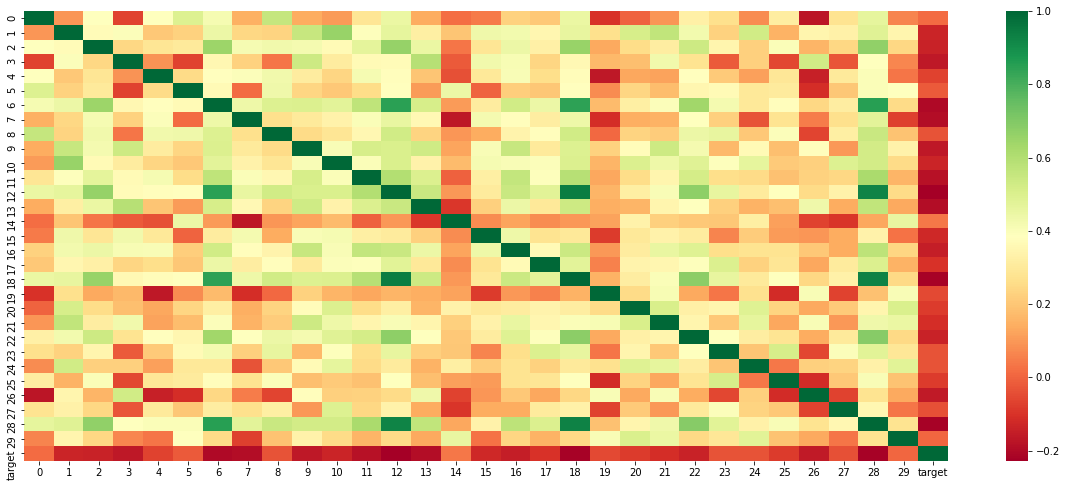

In [23]:
# Выделяем признаки и метки из составленного датафрейма 
print(y_train.shape[0])
data_pd_lda_features_train = data_pd_lda_features.iloc[:y_train.shape[0]]
data_pd_lda_features_train['target'] = y_train
data_pd_lda_features_test = data_pd_lda_features.iloc[y_train.shape[0]:]

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(20.7, 8.27)
sns.heatmap(data_pd_lda_features_train.corr(method = 'spearman'), cmap="RdYlGn", ax = ax)

#### Разбиваем тренировочную выборку на train и test для проверки модели

In [24]:
# Добавляем в качестве признаков получившийся датасет из модели lda
X_tr = sparse.hstack([sparse_train, data_pd_lda_features_train.drop('target', axis = 1)]).tocsr()
print(X_tr[:5])

  (0, 5)	4.0
  (0, 6)	1.0
  (0, 25)	5.0
  (0, 27)	5.0
  (0, 37)	3.0
  (0, 42)	5.0
  (0, 49)	2.0
  (0, 58)	1.0
  (0, 60)	22.0
  (0, 62)	1.0
  (0, 66)	1.0
  (0, 79)	2.0
  (0, 94)	2.0
  (0, 105)	2.0
  (0, 124)	2.0
  (0, 142)	3.0
  (0, 144)	1.0
  (0, 148)	1.0
  (0, 157)	2.0
  (0, 158)	1.0
  (0, 159)	1.0
  (0, 163)	1.0
  (0, 169)	1.0
  (0, 173)	18.0
  (0, 186)	3.0
  :	:
  (4, 918)	0.023682566359639168
  (4, 919)	7.491353608202189e-05
  (4, 920)	7.491353608202189e-05
  (4, 921)	0.004885476548224688
  (4, 922)	7.491353608202189e-05
  (4, 923)	7.491353608202189e-05
  (4, 924)	7.491353608202189e-05
  (4, 925)	7.491353608202189e-05
  (4, 926)	7.491353608202189e-05
  (4, 927)	0.06155296787619591
  (4, 928)	7.491353608202189e-05
  (4, 929)	7.491353608202189e-05
  (4, 930)	0.22788651287555695
  (4, 931)	7.491353608202189e-05
  (4, 932)	7.491353608202189e-05
  (4, 933)	7.491353608202189e-05
  (4, 934)	7.491353608202189e-05
  (4, 935)	7.491353608202189e-05
  (4, 936)	7.491353608202189e-05
  (4, 937)	

In [25]:
X_test = sparse.hstack([sparse_test, data_pd_lda_features.iloc[y_train.shape[0]:]]).tocsr()

In [26]:
ridge = Ridge(random_state=17)
ridge.fit(X_tr,y_train)

Ridge(random_state=17)

In [27]:
# Результат загружаем на Kaggle
subm = ridge.predict(X_test)

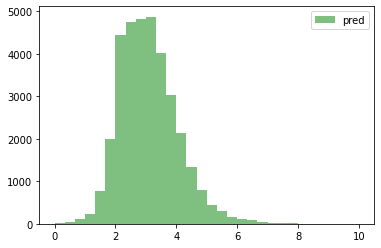

In [28]:
plt.hist(subm, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [29]:
def write_submission(pred, filename, path_to_sample=os.path.join(path_to_data, 'sample_submission.csv')):
    sub = pd.read_csv(path_to_sample, index_col='id')
    sub['log_recommends'] = pred
    sub.to_csv(filename)

In [30]:
write_submission(subm, os.path.join(path_to_data, 'lda_ridge_result.csv'))

### write_submission(ridge_test_pred, os.path.join(path_to_data, 'first_ridge4.csv'))

#### Предыдущий итоговый результат Kaggle (с CountVectorizer) :

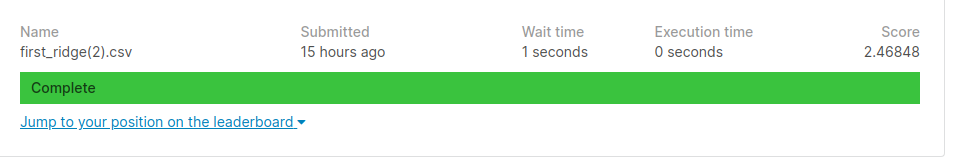

#### Предыдущий итоговый результат Kaggle (с использованием TF-IDF меры) :

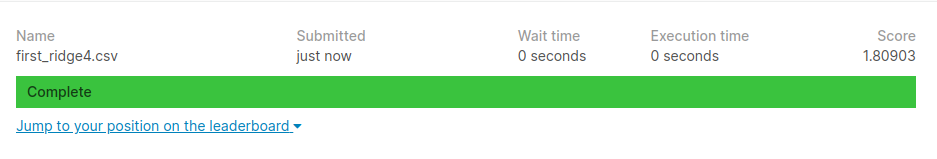


#### Текущий итоговый результат Kaggle (с использованием признаков из модели LDA) :

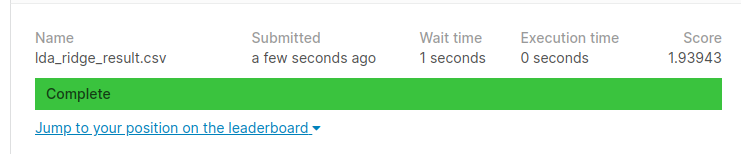

#### Сделать выборку только с признаками LDA